In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import math
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchmetrics
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchinfo import summary

# Hyperparameters

In [28]:
DATASET_DIR = "/Users/hojae/Desktop/goal/genAI/GAN/dataset"
MODEL_SAVE_PATH = './dcgan_model_checkpoint.pth'
IMAGE_SIZE = 64
BATCH_SIZE = 128

CHANNELS = 1
Z_DIM = 100
EPOCHS = 100 
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

# Dataset

In [3]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
def denormalize(img_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    
    img_tensor = img_tensor.clone()  
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)  # t = t * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)
    return img_tensor

def display_sample_batch(loader):
    images = next(iter(loader))
    
    # 정규화 해제 (이미지 복원)
    images = denormalize(images)
    
    grid_img = torchvision.utils.make_grid(images[:10], nrow=10)  # 10개의 이미지를 가로로 출력
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

Total number of images in the train dataset: 40000


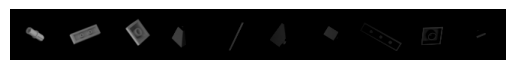

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),   # 이미지 크기 조정
    transforms.Grayscale(num_output_channels=1),   # 흑백으로 변환 (1채널로 설정)
    transforms.ToTensor(),                         # 텐서로 변환
    transforms.Normalize(mean=[0.5], std=[0.5])    # [-1, 1] 범위로 정규화
])

train_data = ImageDataset(image_dir=DATASET_DIR, 
                          transform=transform)

train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          drop_last=False)
print(f"Total number of images in the train dataset: {len(train_data)}")
display_sample_batch(train_loader)

# GAN Implementation

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, image_size, channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.model(x)
        return x.view(x.size(0), -1)  # Flatten

In [7]:
discriminator = Discriminator(image_size=IMAGE_SIZE, channels=CHANNELS)
input_size = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
summary(discriminator, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [128, 1]                  --
├─Sequential: 1-1                        [128, 1, 1, 1]            --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         1,024
│    └─LeakyReLU: 2-2                    [128, 64, 32, 32]         --
│    └─Dropout: 2-3                      [128, 64, 32, 32]         --
│    └─Conv2d: 2-4                       [128, 128, 16, 16]        131,072
│    └─BatchNorm2d: 2-5                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-6                    [128, 128, 16, 16]        --
│    └─Dropout: 2-7                      [128, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [128, 256, 8, 8]          524,288
│    └─BatchNorm2d: 2-9                  [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-10                   [128, 256, 8, 8]          --
│    └─Dropout: 2-11                     [128, 256, 8, 8]          --


## Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1, 1, 1)  # (batch_size, z_dim) -> (batch_size, z_dim, 1, 1)
        return self.model(x)

In [9]:
generator = Generator(z_dim=Z_DIM, channels=CHANNELS)
summary(generator, input_size=(BATCH_SIZE, Z_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [128, 1, 64, 64]          --
├─Sequential: 1-1                        [128, 1, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [128, 512, 4, 4]          819,200
│    └─BatchNorm2d: 2-2                  [128, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-3                    [128, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [128, 256, 8, 8]          2,097,152
│    └─BatchNorm2d: 2-5                  [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-6                    [128, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [128, 128, 16, 16]        524,288
│    └─BatchNorm2d: 2-8                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-9                    [128, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [128, 64, 32, 32]         131,072
│    └─BatchNorm2d: 2-11                 [128, 64, 32, 32]

## GAN

In [25]:
class DCGAN(nn.Module):
    def __init__(self, discriminator, generator, latent_dim, noise_param=0.1):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
        # Loss function (Binary Cross Entropy)
        self.loss_fn = nn.BCELoss()

        # Metrics
        self.d_loss_metric = torchmetrics.MeanMetric()
        self.d_real_acc_metric = torchmetrics.Accuracy(task="binary")
        self.d_fake_acc_metric = torchmetrics.Accuracy(task="binary")
        self.d_acc_metric = torchmetrics.Accuracy(task="binary")
        self.g_loss_metric = torchmetrics.MeanMetric()
        self.g_acc_metric = torchmetrics.Accuracy(task="binary")
        
        # Optimizer
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), 
                                      lr=LEARNING_RATE, 
                                      betas=(ADAM_BETA_1, ADAM_BETA_2))
        self.g_optimizer = optim.Adam(self.generator.parameters(), 
                                      lr=LEARNING_RATE, 
                                      betas=(ADAM_BETA_1, ADAM_BETA_2))
    
    def forward(self, x):
        return self.generator(x)
    
    def train_step(self, real_images):
        batch_size = real_images.size(0)
        device = real_images.device

        # Random latent vectors for generator input
        random_latent_vectors = torch.randn(batch_size, self.latent_dim, 1, 1, device=device)
        generated_images = self.generator(random_latent_vectors)

        # Train Discriminator
        self.discriminator.zero_grad()

        # Real images
        real_predictions = self.discriminator(real_images)
        real_labels = torch.ones_like(real_predictions, device=device)
        real_noisy_labels = real_labels + NOISE_PARAM * torch.rand_like(real_predictions)

        # Clamp the noisy labels to be in the range [0, 1]
        real_noisy_labels = torch.clamp(real_noisy_labels, 0, 1)

        # Fake images
        fake_predictions = self.discriminator(generated_images.detach())
        fake_labels = torch.zeros_like(fake_predictions, device=device)
        fake_noisy_labels = fake_labels - NOISE_PARAM * torch.rand_like(fake_predictions)

        # Clamp the noisy labels to be in the range [0, 1]
        fake_noisy_labels = torch.clamp(fake_noisy_labels, 0, 1)

        # Discriminator loss
        d_real_loss = self.loss_fn(real_predictions, real_noisy_labels)
        d_fake_loss = self.loss_fn(fake_predictions, fake_noisy_labels)
        d_loss = (d_real_loss + d_fake_loss) / 2.0
        d_loss.backward()
        self.d_optimizer.step()

        # Train Generator
        self.generator.zero_grad()
        fake_predictions = self.discriminator(generated_images)
        g_loss = self.loss_fn(fake_predictions, real_labels)
        g_loss.backward()
        self.g_optimizer.step()

        # Apply threshold for binary accuracy calculation (fake_predictions > 0.5 -> 1, else 0)
        binary_fake_predictions = (fake_predictions > 0.5).float()

        # Update metrics
        self.d_loss_metric.update(d_loss.item())
        self.d_acc_metric.update(torch.cat((real_predictions, fake_predictions)), torch.cat((real_labels, fake_labels)))
        self.g_loss_metric.update(g_loss.item())
        self.g_acc_metric.update(real_labels, binary_fake_predictions)  # Correctly update g_acc_metric after each batch

        return {
            'd_loss': self.d_loss_metric.compute(),
            'd_real_acc': self.d_real_acc_metric.compute(),
            'd_fake_acc': self.d_fake_acc_metric.compute(),
            'd_acc': self.d_acc_metric.compute(),
            'g_loss': self.g_loss_metric.compute(),
            'g_acc': self.g_acc_metric.compute(),
        }

In [21]:
discriminator = Discriminator(image_size=IMAGE_SIZE, channels=CHANNELS)
generator = Generator(z_dim=Z_DIM, channels=CHANNELS)
dcgan = DCGAN(discriminator, generator, latent_dim=Z_DIM)

# Train

In [22]:
class ImageGenerator:
    def __init__(self, model, num_img, latent_dim, save_dir="./output"):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.model = model
        self.save_dir = save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    
    def on_epoch_end(self, epoch):
        random_latent_vectors = torch.randn(self.num_img, self.latent_dim, 1, 1).to(next(self.model.generator.parameters()).device)
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 0.5 + 0.5)  # [-1, 1] 범위를 [0, 1]로 변환
        save_path = os.path.join(self.save_dir, f"generated_img_{epoch:03d}.png")
        save_image(generated_images, save_path, nrow=5)
        print(f"Saved to {save_path}")

In [26]:
def train_dcgan(dcgan, train_loader, epochs):
    image_generator = ImageGenerator(dcgan, num_img=10, latent_dim=Z_DIM, save_dir="./output")
    for epoch in range(epochs):
        dcgan.train()  # 모델을 학습 모드로 설정
        d_loss_epoch, g_loss_epoch = 0, 0

        # tqdm을 사용한 학습 진행 상황 출력
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for real_images in train_loader:
                real_images = real_images.to(next(dcgan.parameters()).device)

                # 각 배치에 대해 train_step 호출
                metrics = dcgan.train_step(real_images)

                # 배치 손실을 누적
                d_loss_epoch += metrics['d_loss']
                g_loss_epoch += metrics['g_loss']

                # tqdm의 진행 바 업데이트 및 손실 정보 출력
                pbar.set_postfix({
                    'd_loss': f"{metrics['d_loss']:.4f}",
                    'd_acc': f"{metrics['d_acc']:.4f}",
                    'g_loss': f"{metrics['g_loss']:.4f}",
                    'g_acc': f"{metrics['g_acc']:.4f}"
                })
                pbar.update(1)

        # 에포크 끝난 후 평균 손실 출력
        print(f"\nEpoch {epoch+1}/{epochs} - d_loss: {d_loss_epoch/len(train_loader):.4f} - "
              f"g_loss: {g_loss_epoch/len(train_loader):.4f}")
        
        # 에포크가 끝날 때 이미지 생성 및 저장
        image_generator.on_epoch_end(epoch)

In [27]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available.")
else:
    device = torch.device("cpu")
    print("MPS device is not available. Using CPU.")
    
discriminator = Discriminator(image_size=IMAGE_SIZE, channels=CHANNELS).to(device)
generator = Generator(z_dim=Z_DIM, channels=CHANNELS).to(device)
dcgan = DCGAN(discriminator, generator, latent_dim=Z_DIM).to(device)
train_dcgan(dcgan, train_loader, epochs=EPOCHS)

MPS device is available.


Epoch 1/100: 100%|██████████| 313/313 [02:52<00:00,  1.81batch/s, d_loss=0.0105, d_acc=0.9984, g_loss=7.8531, g_acc=0.0009]



Epoch 1/100 - d_loss: 0.0470 - g_loss: 6.4093
Saved to ./output/generated_img_000.png


Epoch 2/100: 100%|██████████| 313/313 [02:46<00:00,  1.88batch/s, d_loss=0.0918, d_acc=0.9913, g_loss=9.4792, g_acc=0.0061]



Epoch 2/100 - d_loss: 0.0037 - g_loss: 9.3804
Saved to ./output/generated_img_001.png


Epoch 3/100: 100%|██████████| 313/313 [03:35<00:00,  1.45batch/s, d_loss=0.3312, d_acc=0.9033, g_loss=4.5950, g_acc=0.0574]



Epoch 3/100 - d_loss: 0.1753 - g_loss: 6.1605
Saved to ./output/generated_img_002.png


Epoch 4/100: 100%|██████████| 313/313 [02:45<00:00,  1.90batch/s, d_loss=0.4500, d_acc=0.8725, g_loss=2.2424, g_acc=0.0639]



Epoch 4/100 - d_loss: 0.4763 - g_loss: 2.1117
Saved to ./output/generated_img_003.png


Epoch 5/100: 100%|██████████| 313/313 [02:50<00:00,  1.83batch/s, d_loss=0.4183, d_acc=0.8912, g_loss=2.5488, g_acc=0.0426]



Epoch 5/100 - d_loss: 0.4006 - g_loss: 2.6311
Saved to ./output/generated_img_004.png


Epoch 6/100: 100%|██████████| 313/313 [02:48<00:00,  1.86batch/s, d_loss=0.3682, d_acc=0.9057, g_loss=2.7669, g_acc=0.0398]



Epoch 6/100 - d_loss: 0.3759 - g_loss: 2.7210
Saved to ./output/generated_img_005.png


Epoch 7/100: 100%|██████████| 313/313 [02:46<00:00,  1.89batch/s, d_loss=0.3857, d_acc=0.8980, g_loss=2.5543, g_acc=0.0363]



Epoch 7/100 - d_loss: 0.3863 - g_loss: 2.5931
Saved to ./output/generated_img_006.png


Epoch 8/100: 100%|██████████| 313/313 [02:51<00:00,  1.82batch/s, d_loss=0.3796, d_acc=0.8932, g_loss=2.5908, g_acc=0.0455]



Epoch 8/100 - d_loss: 0.3926 - g_loss: 2.6535
Saved to ./output/generated_img_007.png


Epoch 9/100: 100%|██████████| 313/313 [02:52<00:00,  1.82batch/s, d_loss=0.3663, d_acc=0.9007, g_loss=2.6660, g_acc=0.0444]



Epoch 9/100 - d_loss: 0.3588 - g_loss: 2.9301
Saved to ./output/generated_img_008.png


Epoch 10/100: 100%|██████████| 313/313 [02:49<00:00,  1.85batch/s, d_loss=0.3493, d_acc=0.8979, g_loss=2.6094, g_acc=0.0532]



Epoch 10/100 - d_loss: 0.3457 - g_loss: 2.6588
Saved to ./output/generated_img_009.png


Epoch 11/100: 100%|██████████| 313/313 [02:47<00:00,  1.87batch/s, d_loss=0.3403, d_acc=0.9059, g_loss=2.6685, g_acc=0.0515]



Epoch 11/100 - d_loss: 0.3416 - g_loss: 2.7281
Saved to ./output/generated_img_010.png


Epoch 12/100: 100%|██████████| 313/313 [02:50<00:00,  1.84batch/s, d_loss=0.3171, d_acc=0.9123, g_loss=2.6776, g_acc=0.0500]



Epoch 12/100 - d_loss: 0.3076 - g_loss: 2.7095
Saved to ./output/generated_img_011.png


Epoch 13/100: 100%|██████████| 313/313 [02:50<00:00,  1.83batch/s, d_loss=0.3117, d_acc=0.9181, g_loss=2.8449, g_acc=0.0435]



Epoch 13/100 - d_loss: 0.3177 - g_loss: 2.8747
Saved to ./output/generated_img_012.png


Epoch 14/100: 100%|██████████| 313/313 [02:47<00:00,  1.87batch/s, d_loss=0.3093, d_acc=0.9079, g_loss=2.8048, g_acc=0.0549]



Epoch 14/100 - d_loss: 0.3076 - g_loss: 2.8659
Saved to ./output/generated_img_013.png


Epoch 15/100: 100%|██████████| 313/313 [02:48<00:00,  1.85batch/s, d_loss=0.2892, d_acc=0.9143, g_loss=2.8157, g_acc=0.0571]



Epoch 15/100 - d_loss: 0.2930 - g_loss: 2.7004
Saved to ./output/generated_img_014.png


Epoch 16/100: 100%|██████████| 313/313 [02:50<00:00,  1.83batch/s, d_loss=0.2741, d_acc=0.9241, g_loss=2.8993, g_acc=0.0458]



Epoch 16/100 - d_loss: 0.2751 - g_loss: 2.7889
Saved to ./output/generated_img_015.png


Epoch 17/100: 100%|██████████| 313/313 [02:46<00:00,  1.88batch/s, d_loss=0.2840, d_acc=0.9140, g_loss=2.8820, g_acc=0.0580]



Epoch 17/100 - d_loss: 0.2844 - g_loss: 2.8374
Saved to ./output/generated_img_016.png


Epoch 18/100: 100%|██████████| 313/313 [02:50<00:00,  1.83batch/s, d_loss=0.2545, d_acc=0.9261, g_loss=2.8615, g_acc=0.0532]



Epoch 18/100 - d_loss: 0.2623 - g_loss: 2.8317
Saved to ./output/generated_img_017.png


Epoch 19/100: 100%|██████████| 313/313 [02:48<00:00,  1.85batch/s, d_loss=0.2354, d_acc=0.9338, g_loss=3.1219, g_acc=0.0428]



Epoch 19/100 - d_loss: 0.2613 - g_loss: 3.0335
Saved to ./output/generated_img_018.png


Epoch 20/100: 100%|██████████| 313/313 [02:48<00:00,  1.86batch/s, d_loss=0.2419, d_acc=0.9320, g_loss=3.0541, g_acc=0.0444]



Epoch 20/100 - d_loss: 0.2632 - g_loss: 3.0556
Saved to ./output/generated_img_019.png


Epoch 21/100: 100%|██████████| 313/313 [02:51<00:00,  1.82batch/s, d_loss=0.2216, d_acc=0.9353, g_loss=3.1444, g_acc=0.0449]



Epoch 21/100 - d_loss: 0.2208 - g_loss: 3.1216
Saved to ./output/generated_img_020.png


Epoch 22/100: 100%|██████████| 313/313 [02:49<00:00,  1.85batch/s, d_loss=0.2228, d_acc=0.9350, g_loss=3.1938, g_acc=0.0459]



Epoch 22/100 - d_loss: 0.2288 - g_loss: 3.1559
Saved to ./output/generated_img_021.png


Epoch 23/100: 100%|██████████| 313/313 [02:48<00:00,  1.86batch/s, d_loss=0.2367, d_acc=0.9250, g_loss=3.1784, g_acc=0.0494]



Epoch 23/100 - d_loss: 0.2554 - g_loss: 3.1283
Saved to ./output/generated_img_022.png


Epoch 24/100: 100%|██████████| 313/313 [02:49<00:00,  1.85batch/s, d_loss=0.2406, d_acc=0.9258, g_loss=3.1785, g_acc=0.0546]



Epoch 24/100 - d_loss: 0.2384 - g_loss: 3.1272
Saved to ./output/generated_img_023.png


Epoch 25/100: 100%|██████████| 313/313 [02:47<00:00,  1.87batch/s, d_loss=0.2299, d_acc=0.9298, g_loss=3.2322, g_acc=0.0510]



Epoch 25/100 - d_loss: 0.2272 - g_loss: 3.2089
Saved to ./output/generated_img_024.png


Epoch 26/100: 100%|██████████| 313/313 [02:47<00:00,  1.87batch/s, d_loss=0.2158, d_acc=0.9334, g_loss=3.3622, g_acc=0.0468]



Epoch 26/100 - d_loss: 0.1963 - g_loss: 3.3568
Saved to ./output/generated_img_025.png


Epoch 27/100: 100%|██████████| 313/313 [02:49<00:00,  1.85batch/s, d_loss=0.1796, d_acc=0.9514, g_loss=3.5879, g_acc=0.0312]



Epoch 27/100 - d_loss: 0.1715 - g_loss: 3.6033
Saved to ./output/generated_img_026.png


Epoch 28/100: 100%|██████████| 313/313 [02:49<00:00,  1.85batch/s, d_loss=0.2187, d_acc=0.9336, g_loss=3.5372, g_acc=0.0477]



Epoch 28/100 - d_loss: 0.2468 - g_loss: 3.5434
Saved to ./output/generated_img_027.png


Epoch 29/100: 100%|██████████| 313/313 [02:48<00:00,  1.85batch/s, d_loss=0.1967, d_acc=0.9427, g_loss=3.5234, g_acc=0.0454]



Epoch 29/100 - d_loss: 0.2055 - g_loss: 3.4498
Saved to ./output/generated_img_028.png


Epoch 30/100: 100%|██████████| 313/313 [02:47<00:00,  1.86batch/s, d_loss=0.1826, d_acc=0.9462, g_loss=3.5945, g_acc=0.0392]



Epoch 30/100 - d_loss: 0.1618 - g_loss: 3.7813
Saved to ./output/generated_img_029.png


Epoch 31/100: 100%|██████████| 313/313 [02:54<00:00,  1.79batch/s, d_loss=0.2010, d_acc=0.9370, g_loss=3.5692, g_acc=0.0474]



Epoch 31/100 - d_loss: 0.1874 - g_loss: 3.6447
Saved to ./output/generated_img_030.png


Epoch 32/100: 100%|██████████| 313/313 [02:49<00:00,  1.85batch/s, d_loss=0.1691, d_acc=0.9493, g_loss=3.7840, g_acc=0.0382]



Epoch 32/100 - d_loss: 0.1584 - g_loss: 3.7793
Saved to ./output/generated_img_031.png


Epoch 33/100: 100%|██████████| 313/313 [02:51<00:00,  1.82batch/s, d_loss=0.1818, d_acc=0.9415, g_loss=3.6624, g_acc=0.0463]



Epoch 33/100 - d_loss: 0.2100 - g_loss: 3.4593
Saved to ./output/generated_img_032.png


Epoch 34/100: 100%|██████████| 313/313 [02:50<00:00,  1.83batch/s, d_loss=0.1962, d_acc=0.9415, g_loss=3.7812, g_acc=0.0436]



Epoch 34/100 - d_loss: 0.1947 - g_loss: 3.8991
Saved to ./output/generated_img_033.png


Epoch 35/100: 100%|██████████| 313/313 [02:47<00:00,  1.87batch/s, d_loss=0.1794, d_acc=0.9471, g_loss=3.7280, g_acc=0.0435]



Epoch 35/100 - d_loss: 0.1810 - g_loss: 3.6911
Saved to ./output/generated_img_034.png


Epoch 36/100: 100%|██████████| 313/313 [02:47<00:00,  1.86batch/s, d_loss=0.1580, d_acc=0.9570, g_loss=3.9186, g_acc=0.0297]



Epoch 36/100 - d_loss: 0.1490 - g_loss: 3.9824
Saved to ./output/generated_img_035.png


Epoch 37/100: 100%|██████████| 313/313 [02:50<00:00,  1.84batch/s, d_loss=0.1919, d_acc=0.9405, g_loss=3.7955, g_acc=0.0439]



Epoch 37/100 - d_loss: 0.2117 - g_loss: 3.8506
Saved to ./output/generated_img_036.png


Epoch 38/100: 100%|██████████| 313/313 [02:48<00:00,  1.85batch/s, d_loss=0.1622, d_acc=0.9488, g_loss=3.9973, g_acc=0.0409]



Epoch 38/100 - d_loss: 0.1473 - g_loss: 3.9588
Saved to ./output/generated_img_037.png


Epoch 39/100: 100%|██████████| 313/313 [02:51<00:00,  1.83batch/s, d_loss=0.1801, d_acc=0.9431, g_loss=3.8710, g_acc=0.0450]



Epoch 39/100 - d_loss: 0.1752 - g_loss: 3.8605
Saved to ./output/generated_img_038.png


Epoch 40/100: 100%|██████████| 313/313 [02:50<00:00,  1.84batch/s, d_loss=0.1508, d_acc=0.9576, g_loss=4.0392, g_acc=0.0309]



Epoch 40/100 - d_loss: 0.1647 - g_loss: 3.9805
Saved to ./output/generated_img_039.png


Epoch 41/100: 100%|██████████| 313/313 [02:50<00:00,  1.83batch/s, d_loss=0.1661, d_acc=0.9520, g_loss=4.0950, g_acc=0.0352]



Epoch 41/100 - d_loss: 0.1571 - g_loss: 4.2527
Saved to ./output/generated_img_040.png


Epoch 42/100: 100%|██████████| 313/313 [02:49<00:00,  1.85batch/s, d_loss=0.1862, d_acc=0.9438, g_loss=4.0204, g_acc=0.0450]



Epoch 42/100 - d_loss: 0.1769 - g_loss: 4.0752
Saved to ./output/generated_img_041.png


Epoch 43/100: 100%|██████████| 313/313 [02:47<00:00,  1.86batch/s, d_loss=0.1537, d_acc=0.9532, g_loss=4.0997, g_acc=0.0354]



Epoch 43/100 - d_loss: 0.1866 - g_loss: 3.8894
Saved to ./output/generated_img_042.png


Epoch 44/100: 100%|██████████| 313/313 [02:50<00:00,  1.84batch/s, d_loss=0.1954, d_acc=0.9382, g_loss=4.0030, g_acc=0.0516]



Epoch 44/100 - d_loss: 0.1872 - g_loss: 4.1610
Saved to ./output/generated_img_043.png


Epoch 45/100: 100%|██████████| 313/313 [02:50<00:00,  1.83batch/s, d_loss=0.1618, d_acc=0.9511, g_loss=4.1090, g_acc=0.0373]



Epoch 45/100 - d_loss: 0.1193 - g_loss: 4.1590
Saved to ./output/generated_img_044.png


Epoch 46/100: 100%|██████████| 313/313 [02:50<00:00,  1.84batch/s, d_loss=0.1400, d_acc=0.9602, g_loss=4.1974, g_acc=0.0298]



Epoch 46/100 - d_loss: 0.1342 - g_loss: 4.1172
Saved to ./output/generated_img_045.png


Epoch 47/100: 100%|██████████| 313/313 [02:58<00:00,  1.75batch/s, d_loss=0.1520, d_acc=0.9527, g_loss=4.1138, g_acc=0.0417]



Epoch 47/100 - d_loss: 0.1433 - g_loss: 4.2361
Saved to ./output/generated_img_046.png


Epoch 48/100: 100%|██████████| 313/313 [03:22<00:00,  1.55batch/s, d_loss=0.1183, d_acc=0.9658, g_loss=4.3223, g_acc=0.0291]



Epoch 48/100 - d_loss: 0.1656 - g_loss: 4.1450
Saved to ./output/generated_img_047.png


Epoch 49/100: 100%|██████████| 313/313 [02:57<00:00,  1.77batch/s, d_loss=0.1476, d_acc=0.9531, g_loss=4.3841, g_acc=0.0429]



Epoch 49/100 - d_loss: 0.1381 - g_loss: 4.4503
Saved to ./output/generated_img_048.png


Epoch 50/100: 100%|██████████| 313/313 [02:51<00:00,  1.83batch/s, d_loss=0.2281, d_acc=0.9280, g_loss=3.7684, g_acc=0.0603]



Epoch 50/100 - d_loss: 0.2767 - g_loss: 3.6977
Saved to ./output/generated_img_049.png


Epoch 51/100:  11%|█         | 35/313 [00:19<02:35,  1.79batch/s, d_loss=0.1349, d_acc=0.9628, g_loss=4.3417, g_acc=0.0263]


KeyboardInterrupt: 

In [29]:
def save_model_and_visualize(epoch, dcgan, d_loss_history, g_loss_history, d_acc_history, g_acc_history):
    # 모델 파라미터 저장
    torch.save(dcgan.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved after epoch {epoch} at {MODEL_SAVE_PATH}")
    
    # 메트릭 시각화
    epochs_range = list(range(1, epoch + 1))
    
    plt.figure(figsize=(12, 6))
    
    # Discriminator와 Generator의 손실 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, d_loss_history, label='Discriminator Loss')
    plt.plot(epochs_range, g_loss_history, label='Generator Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Discriminator와 Generator의 정확도 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, d_acc_history, label='Discriminator Accuracy')
    plt.plot(epochs_range, g_acc_history, label='Generator Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [30]:
torch.save(dcgan.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved after epoch {50} at {MODEL_SAVE_PATH}")

Model saved after epoch 50 at ./dcgan_model_checkpoint.pth
